In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,6)})

## 5.3.1 Import the data

In [2]:
# Import the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/loan_final313.csv")
print(df.shape)
df.head()

(887379, 30)


,id,year,issue_d,final_d,emp_length_int,home_ownership,home_ownership_cat,income_category,annual_inc,income_cat,loan_amount,term,term_cat,application_type,application_type_cat,purpose,purpose_cat,interest_payments,interest_payment_cat,loan_condition,loan_condition_cat,interest_rate,grade,grade_cat,dti,total_pymnt,total_rec_prncp,recoveries,installment,region
0,1077501,2011,01/12/2011,1012015,10.0,RENT,1,Low,24000,1,5000,36 months,1,INDIVIDUAL,1,credit_card,1,Low,1,Good Loan,0,10.65,B,2,27.65,5861.071414,5000.00,0.00,162.87,munster
1,1077430,2011,01/12/2011,1042013,0.5,RENT,1,Low,30000,1,2500,60 months,2,INDIVIDUAL,1,car,2,High,2,Bad Loan,1,15.27,C,3,1.00,1008.710000,456.46,117.08,59.83,leinster
2,1077175,2011,01/12/2011,1062014,10.0,RENT,1,Low,12252,1,2400,36 months,1,INDIVIDUAL,1,small_business,3,High,2,Good Loan,0,15.96,C,3,8.72,3003.653644,2400.00,0.00,84.33,cannught
3,1076863,2011,01/12/2011,1012015,10.0,RENT,1,Low,49200,1,10000,36 months,1,INDIVIDUAL,1,other,4,High,2,Good Loan,0,13.49,C,3,20.00,12226.302210,10000.00,0.00,339.31,ulster
4,1075358,2011,01/12/2011,1012016,1.0,RENT,1,Low,80000,1,3000,60 months,2,INDIVIDUAL,1,other,4,Low,1,Good Loan,0,12.69,B,2,17.94,3242.170000,2233.10,0.00,67.79,ulster


## 5.3.2 Feature Engineering

In [3]:
# Choose 10 major features
df0 = df.iloc[:, [8, 4, 21, 10, 12, 20, 6, 16, 18, 23]]
display(df0.head())

# Independent features X 
X1 = df0.iloc[:, :-1]

# Response feature y
y1 = df0.iloc[:, -1]

,annual_inc,emp_length_int,interest_rate,loan_amount,term_cat,loan_condition_cat,home_ownership_cat,purpose_cat,interest_payment_cat,grade_cat
0,24000,10.0,10.65,5000,1,0,1,1,1,2
1,30000,0.5,15.27,2500,2,1,1,2,2,3
2,12252,10.0,15.96,2400,1,0,1,3,2,3
3,49200,10.0,13.49,10000,1,0,1,4,2,3
4,80000,1.0,12.69,3000,2,0,1,4,1,2


# 5.3.3 Normalization

In [4]:
# Min-max scaling
X1_scale = pd.DataFrame(MinMaxScaler().fit_transform(X1))
X1_scale.columns = X1.columns
X1_scale.head()

,annual_inc,emp_length_int,interest_rate,loan_amount,term_cat,loan_condition_cat,home_ownership_cat,purpose_cat,interest_payment_cat
0,0.002526,1.000000,0.225180,0.130435,0.0,0.0,0.0,0.000000,0.0
1,0.003158,0.000000,0.420363,0.057971,1.0,1.0,0.0,0.076923,1.0
2,0.001290,1.000000,0.449514,0.055072,0.0,0.0,0.0,0.153846,1.0
3,0.005179,1.000000,0.345163,0.275362,0.0,0.0,0.0,0.230769,1.0
4,0.008421,0.052632,0.311365,0.072464,1.0,0.0,0.0,0.230769,0.0


## 5.3.4 Modeling

In [5]:
# Split to training and test set
X_train, X_test, y_train, y_test = train_test_split(X1_scale,
                                                    y1,
                                                    stratify = y1,
                                                    test_size = 0.1,
                                                    random_state = 0)


In [6]:
# Fit the model
start = datetime.now()
lgb_clf = LGBMClassifier(n_estimators = 200, 
                         learning_rate = 0.1
                         )

lgb_clf.fit(X_train, y_train)

# Predict 
y_pred = lgb_clf.predict(X_test)

# Accuracy
print("accuracy: ", metrics.accuracy_score(y_test, y_pred))
print(datetime.now()-start)

accuracy:  0.9490635353512588
0:01:38.582680


# 5.3.5 Hyperparameter tuning

In [7]:
# Grid search
lgb_clf = LGBMClassifier()

lgb_param_grid = {'learning_rate': np.arange(0.05, 0.15, 0.05),
                  'n_estimators': np.arange(200, 600, 200)
                  }

random_lgb = RandomizedSearchCV(estimator=lgb_clf, 
                                    param_distributions=lgb_param_grid,
                                    n_iter=100, 
                                    scoring='accuracy', 
                                    cv=2, 
                                    verbose=1,
                                    n_jobs=-1
                                    )
random_lgb.fit(X_train, y_train)
print("Best parameters found: ",random_lgb.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 12.9min finished


Best parameters found:  {'n_estimators': 400, 'learning_rate': 0.1}


In [8]:
# Use the best parameter to caculate accuracy
lgb_clf = LGBMClassifier(n_estimators = 400, 
                         learning_rate = 0.1
                         )
lgb_clf.fit(X_train, y_train)

# Predict 
y_pred = lgb_clf.predict(X_test)

# Accuracy
print("accuracy: ", metrics.accuracy_score(y_test, y_pred))

accuracy:  0.9492889179382001


## 5.3.6 Feature importance

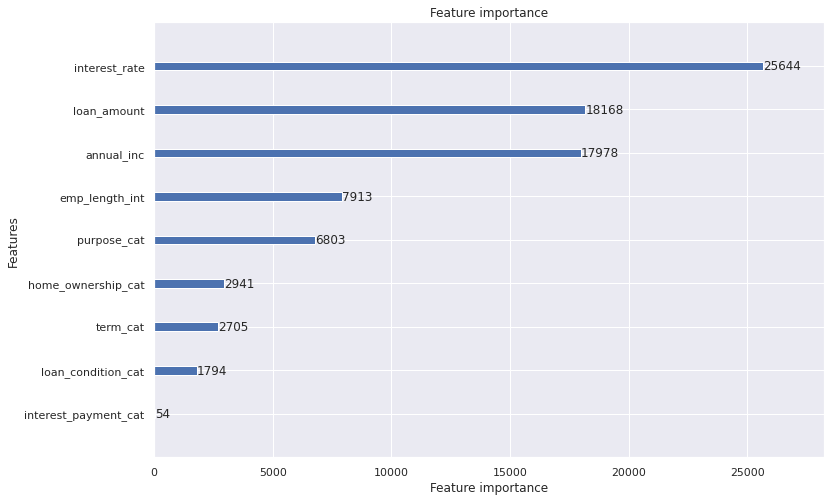

In [9]:
sns.set(rc={'figure.figsize':(12,8)})
plot_importance(lgb_clf)